# Visualization Demo
This notebook aims to generate necessary visualizations for this project report.

In [2]:
from utils.head import ensemble, end2end
from utils.dataset import load_compiled_data, aircraft_camera_data
from utils.training import train_aux, train_de
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchinfo
import pickle as pkl

from matplotlib.lines import Line2D
import time
import os
import numpy as np

device = torch.device('cuda:0')

offset = [[19.75, 248.75, 12.5, 5.5], [10.0, 248.5, 11.5, 5.0]]
divider = [[1893.0, 395.75, 170.625, 151.375],
           [1901.25, 396.5, 171.0, 81.875]]

trajectory_threshold = [800, 700]
init_list = ['kaiming']
desc = 'big_dataset'

In [3]:
test_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode=True, output_directory='output/object_detector', device=device, verbose=False)

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#8d3ed2']

# Frames from Video

## Barely visible aircraft in low visibility conditions:

In [3]:
t = 2  # Time - 5
w = 1  # Weather - 5
r = 1  # Runs - 3

data_indexes = [1, 2]  # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814,
                            103.97961848373048]  # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl',
                 f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources=data_sources,
                           touchdown_target_lat_lon=touchdown_target_lat_lon)

Current Distance: 2.34 nm


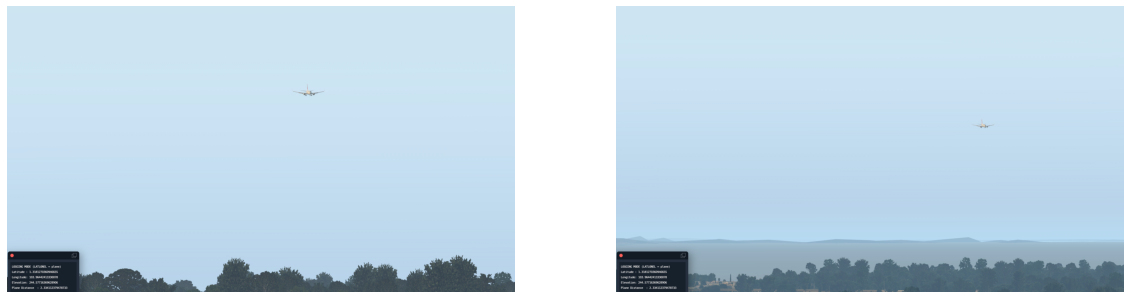

In [8]:
n = 3500
fig, ax = acd.vis_frame(n)
print(f'Current Distance: {acd.get_current_dtt(n):.2f} nm')

In [43]:
fig.savefig("images/foggy_frame.png", dpi=300)

## Inference on Frame

In [44]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/new_od_model.pt',
                offset=offset, divider=divider, device=device)

Input_Reg Aux DE Loaded


Time Profile:

Object Detector    : 101.19 ms
Preprocessing      : 0.43 ms
Distance Estimator : 5.87 ms

Total Time         : 107.49 ms (9.303185566690178 FPS)
            
Error: 0.01 nm


(-0.5, 1919.5, 1079.5, -0.5)

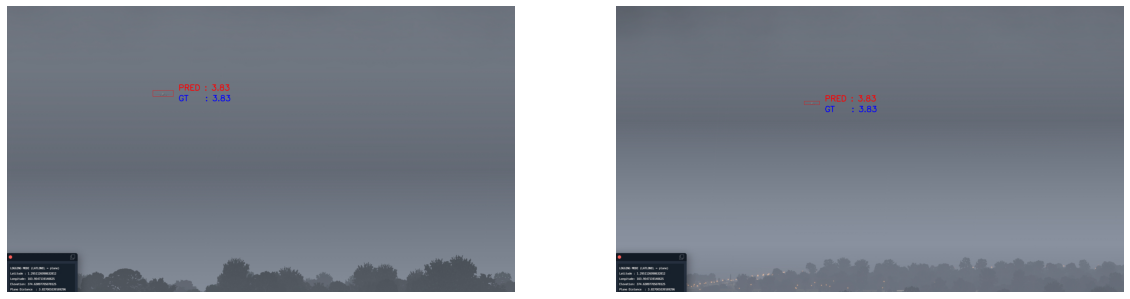

In [50]:
img = acd.get_frame_from_video(n, size=(1280, 1920), batch_size=1).cuda()
box, score, pred = model.single_infer(img)
gt = acd.get_current_dtt(n)

print(f'Error: {abs(pred - gt):.2f} nm')
fig, ax = model.vis(img, box, score, pred, gt)
ax[0].axis('off')
ax[1].axis('off')

In [46]:
fig.savefig("images/foggy_frame_inference.png", dpi=300)

## Frame Trajectory

In [10]:
t = 2  # Time - 5
w = 1  # Weather - 5
r = 1  # Runs - 3

data_indexes = [1, 2]  # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814,
                            103.97961848373048]  # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl',
                 f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources=data_sources,
                           touchdown_target_lat_lon=touchdown_target_lat_lon)
trajectory_data = load_compiled_data(
    ts=[t], ws=[w], rs=[r], inference_mode=True, verbose=False)['x'].numpy()

In [11]:
offset = [[19.75, 248.75, 12.5, 5.5], [10.0, 248.5, 11.5, 5.0]]
divider = [[1893.0, 395.75, 170.625, 151.375],
           [1901.25, 396.5, 171.0, 81.875]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/final_training_m_m.pt',
                offset=offset, divider=divider, device=device)

Input_Reg Aux DE Loaded


Time Profile:

Object Detector    : 124.41 ms
Preprocessing      : 4.64 ms
Distance Estimator : 9.88 ms

Total Time         : 138.94 ms (7.197469914045032 FPS)
            


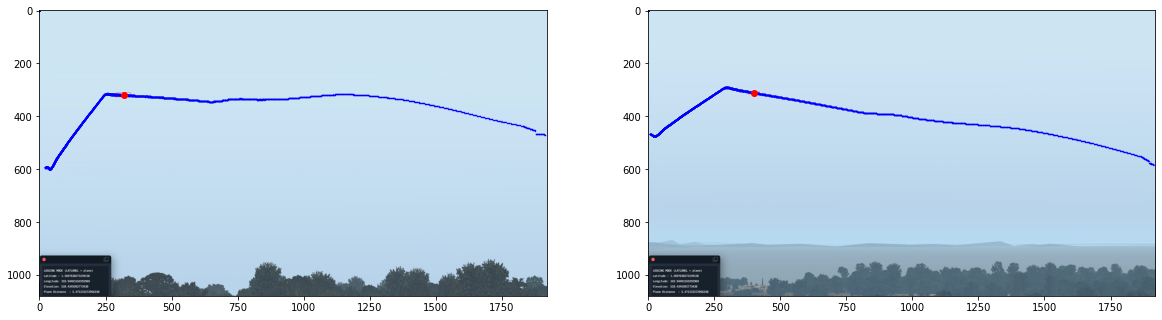

In [12]:
n = 3000
img = acd.get_frame_from_video(n, size=(1280, 1920), batch_size=1).cuda()
box, score, pred = model.single_infer(img)
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
fig, ax = model.vis(img, box, fig=fig, ax=ax)
for i in range(len(img[0])):
    ax[i].scatter(trajectory_data[i, :, 0],
                  trajectory_data[i, :, 1], s=0.1, c='b')
    ax[i].scatter(trajectory_data[i, n, 0], trajectory_data[i, n, 1], c='r')
    #ax[0][0].scatter(((box[0][0] + box[0][2])/2).cpu().numpy(), ((box[0][1] + box[0][3])/2).cpu().numpy(), s = 100)

In [13]:
fig.savefig("images/simulation_trajectory.png", dpi=300)

# "Auto" Training Mode

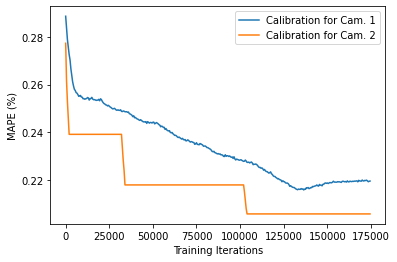

In [90]:
with open('models/head/demo_aux_training_log.pkl', 'rb') as f:
    training_log = pkl.load(f)

fig, ax = plt.subplots(1, 1)
#ax.set_title('Calibration Layer Training w/ Auxilary head')
ax.set_xlabel('Training Iterations')
ax.set_ylabel('MAPE (%)')
plt.plot(np.arange(training_log[1][55:, 0].shape[0]) * 500,
         training_log[1][55:, 0],  label="Calibration for Cam. 1")
plt.plot(np.arange(training_log[1][55:, 0].shape[0]) * 500,
         training_log[1][55:, 1],  label="Calibration for Cam. 2")
plt.legend(loc="upper right")

In [98]:
training_log = model.training_log['de'][1].reshape(-1, 2)

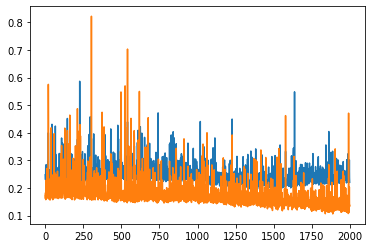

In [100]:
plt.plot(training_log[:, 0])
plt.plot(training_log[:, 1])

In [82]:
fig.savefig("images/adaptive_training.png", dpi=300)

# Percentange of Missing Detections in any camera

In [27]:
temp = load_compiled_data(ts=[1, 2, 3, 4, 5], ws=[1, 2, 3, 4, 5], rs=[
                          1, 2, 3], output_directory='output/object_detector', inference_mode=True)
ff_both = torch.all(torch.any(temp['x'] != 0, dim=2), dim=0)
ff_any = torch.any(torch.any(temp['x'] != 0, dim=2), dim=0)
print(
    f"Loss Data: { (1 - (temp['x'][:, ff_both].shape[1] / temp['x'][:, ff_any].shape[1])) * 100} %")

Loss Data: 14.296370453251672 %


In [7]:
offset = [[19.75, 248.75, 12.5, 5.5], [10.0, 248.5, 11.5, 5.0]]
divider = [[1893.0, 395.75, 170.625, 151.375],
           [1901.25, 396.5, 171.0, 81.875]]

# Model Analysis

In [5]:
model_type = 'm_m'
model = ensemble(f'models/config/model_{model_type}.yaml',
                 model_state_dict=f'models/head/new_od_model.pt', device=device)

Input_Reg Aux DE Loaded


## Single vs Multi-View Model Prediction

In [6]:
test_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode=False, output_directory='output/object_detector', device=device, verbose=False)

In [7]:
single_exclusive_x = torch.cat((torch.stack((test_data['single']['cam_1']['x'], torch.zeros(test_data['single']['cam_1']['x'].shape, device=test_data['single']['cam_1']['x'].device))), torch.stack((torch.zeros(test_data['single']['cam_2']['x'].shape, device=test_data['single']['cam_2']['x'].device), test_data['single']['cam_2']['x']))), dim=1)
single_exclusive_y = torch.cat((test_data['single']['cam_1']['y'], test_data['single']['cam_2']['y']))
f_sort_single = torch.argsort(single_exclusive_y[:, 0])
single_exclusive_x = single_exclusive_x[:, f_sort_single]
single_exclusive_y = single_exclusive_y[f_sort_single]

dual_exclusive_x = torch.stack((test_data['dual']['cam_1']['x'], test_data['dual']['cam_2']['x']))
dual_exclusive_y = test_data['dual']['cam_1']['y']
f_sort_dual = torch.argsort(dual_exclusive_y[:, 0])
dual_exclusive_x = dual_exclusive_x[:, f_sort_dual]
dual_exclusive_y = dual_exclusive_y[f_sort_dual]

In [8]:
single_exclusive_result = ((model(single_exclusive_x) - single_exclusive_y[:, 0]) * 100 / single_exclusive_y[:, 0]).detach().cpu().numpy()
dual_exclusive_result = ((model(dual_exclusive_x) - dual_exclusive_y[:, 0]) * 100 / dual_exclusive_y[:, 0]).detach().cpu().numpy()

  0%|          | 0/31504 [00:00<?, ?it/s]

  0%|          | 0/15138 [00:00<?, ?it/s]

In [328]:
print("Single Result")
print(f"MAPE : {round(abs(single_exclusive_result).mean().item(), 8)}")
print(f"STD  : {round(single_exclusive_result.std().item(), 8)}")
print("")
print("Dual Result")
print(f"MAPE : {round(abs(dual_exclusive_result).mean().item(), 8)}")
print(f"STD  : {round(dual_exclusive_result.std().item(), 8)}")

Single Result
MAPE : 0.23696896
STD  : 0.56190324

Dual Result
MAPE : 0.13080126
STD  : 0.16548736


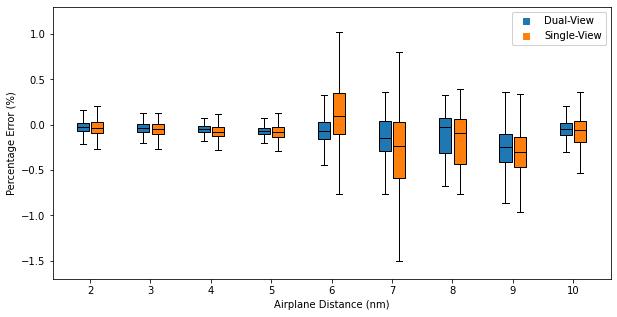

In [329]:
key_distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
f_per_dist_boths = [np.logical_and(
    dual_exclusive_y.cpu().numpy()[:, 0]*10 <= (i+0.5), dual_exclusive_y.cpu().numpy()[:, 0]*10 > (i-0.5)) for i in key_distances]
f_per_dist_singles = [np.logical_and(
    single_exclusive_y.cpu().numpy()[:, 0]*10 <= (i+0.5), single_exclusive_y.cpu().numpy()[:, 0]*10 > (i-0.5)) for i in key_distances]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bps_2 = [single_exclusive_result[i][np.argsort(single_exclusive_result[i])] for i in f_per_dist_singles]
bpb_2 = [dual_exclusive_result[i][np.argsort(dual_exclusive_result[i])] for i in f_per_dist_boths]
bps = ax.boxplot([single_exclusive_result[i][np.argsort(single_exclusive_result[i])] for i in f_per_dist_singles],
                 widths=0.2, patch_artist=True, positions=key_distances+0.12)
bpb = ax.boxplot([dual_exclusive_result[i][np.argsort(dual_exclusive_result[i])] for i in f_per_dist_boths],
                 widths=0.2, patch_artist=True, positions=key_distances-0.12)

#ax.set_title('Single vs Multi-Camera Accuracy')
ax.set_xlabel('Airplane Distance (nm)')
ax.set_ylabel('Percentage Error (%)')

for flier in bpb['fliers']:
    flier.set(marker='x',
              color=colors[0],
              alpha=0.0)

for patch in bpb['boxes']:
    patch.set_facecolor(colors[0])

for median in bpb['medians']:
    median.set(color='black',
               linewidth=1)

for flier in bps['fliers']:
    flier.set(marker='x',
              color=colors[1],
              alpha=0.0)

for patch in bps['boxes']:
    patch.set_facecolor(colors[1])

for median in bps['medians']:
    median.set(color='black',
               linewidth=1)

ax.set_xticks(key_distances)
ax.set_xticklabels(key_distances)

custom_lines_1 = [Line2D([0], [0], color=colors[0], lw=0, marker='s'),
                  Line2D([0], [0], color=colors[1], lw=0, marker='s')]

legend1 = ax.legend(
    custom_lines_1, ['Dual-View', 'Single-View'], loc='upper right')
ax.set_ylim(-1.7, 1.3)
ax.add_artist(legend1)

In [330]:
# MAPE and std at every airplane distance for dual view
print(f"MAPE : {[round(abs(dual_exclusive_result[i]).mean(), 8) for i in f_per_dist_boths]}")
print(f"STD  : {[round(dual_exclusive_result[i].std(), 8) for i in f_per_dist_boths]}")

MAPE : [0.0640548, 0.06653668, 0.06107744, 0.07681334, 0.13018367, 0.2073553, 0.18429755, 0.27612695, 0.09211599]
STD  : [0.08237627, 0.08430815, 0.05643036, 0.06611732, 0.15125242, 0.21676221, 0.22114041, 0.21175659, 0.10690072]


In [331]:
# MAPE and std at every airplane distance for single view
print(f"MAPE : {[round(abs(single_exclusive_result[i]).mean(), 8) for i in f_per_dist_singles]}")
print(f"STD  : {[round(single_exclusive_result[i].std(), 8) for i in f_per_dist_singles]}")

MAPE : [0.11537029, 0.07689256, 0.08459046, 0.09533351, 0.33338392, 0.4418568, 0.25172213, 0.3177308, 0.18806899]
STD  : [0.20500901, 0.08337625, 0.06892977, 0.08401598, 0.4678119, 0.52811235, 0.28425014, 0.22631153, 0.2553822]


In [332]:
fig.savefig("images/single_vs_multicamera.png", dpi=300)

## Effect of Lighting (Time of day) on Accuracy

In [367]:
time_variation_dataset = []
for i in range(1,6):
    if i in [1,2,5]:
        a = [3]
    else:
        a = [1,2,3]
    time_variation_dataset.append(load_compiled_data(ts=[i], ws=[1,3,4,5], rs=a, offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, output_directory='output/object_detector', inference_mode=True, device=device, verbose=False))
    
combination_x = [data['x'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)] for data in time_variation_dataset]
combination_y = [data['y'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)][0] for data in time_variation_dataset]

# inference
combination_result = [(model(combination_x[i]) - combination_y[i][:, 0]) * 100 / combination_y[i][:, 0] for i in range(len(combination_x))]

  0%|          | 0/13200 [00:00<?, ?it/s]

  0%|          | 0/18274 [00:00<?, ?it/s]

  0%|          | 0/53865 [00:00<?, ?it/s]

  0%|          | 0/57009 [00:00<?, ?it/s]

  0%|          | 0/18528 [00:00<?, ?it/s]

In [366]:
time_variation_dataset = []
for i in range(1,6):
    if i in [1,2,5]:
        a = [3]
    else:
        a = [1,2,3]
    time_variation_dataset.append(load_compiled_data(ts=[i], ws=[1,3,4,5], rs=a, offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, output_directory='output/object_detector', inference_mode=False, device=device, verbose=False))
    
single_exclusive_x = [torch.cat((torch.stack((data['single']['cam_1']['x'], torch.zeros(data['single']['cam_1']['x'].shape, device=data['single']['cam_1']['x'].device))), torch.stack((torch.zeros(data['single']['cam_2']['x'].shape, device=data['single']['cam_2']['x'].device), data['single']['cam_2']['x']))), dim=1) for data in time_variation_dataset]
single_exclusive_y = [torch.cat((data['single']['cam_1']['y'], data['single']['cam_2']['y'])) for data in time_variation_dataset]

dual_exclusive_x = [torch.stack((data['dual']['cam_1']['x'], data['dual']['cam_2']['x'])) for data in time_variation_dataset]
dual_exclusive_y = [data['dual']['cam_1']['y'] for data in time_variation_dataset]

# inference
single_exclusive_result = [(model(single_exclusive_x[i]) - single_exclusive_y[i][:, 0]) * 100 / single_exclusive_y[i][:, 0]
                           for i in range(len(single_exclusive_x))]
dual_exclusive_result = [(model(dual_exclusive_x[i]) - dual_exclusive_y[i][:, 0]) * 100 / dual_exclusive_y[i][:, 0]
                         for i in range(len(dual_exclusive_x))] 

  0%|          | 0/23381 [00:00<?, ?it/s]

  0%|          | 0/33600 [00:00<?, ?it/s]

  0%|          | 0/98019 [00:00<?, ?it/s]

  0%|          | 0/105694 [00:00<?, ?it/s]

  0%|          | 0/34282 [00:00<?, ?it/s]

  0%|          | 0/10181 [00:00<?, ?it/s]

  0%|          | 0/15326 [00:00<?, ?it/s]

  0%|          | 0/44152 [00:00<?, ?it/s]

  0%|          | 0/48685 [00:00<?, ?it/s]

  0%|          | 0/15754 [00:00<?, ?it/s]

In [368]:
print("Single View Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in single_exclusive_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in single_exclusive_result]}")
print("")
print("Dual View Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in dual_exclusive_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in dual_exclusive_result]}")
print("")
print("Combination Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in combination_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in combination_result]}")

Single View Result
MAPE : [0.21067691, 0.28968412, 0.27773529, 0.28041783, 0.2437494]
STD  : [0.62468559, 0.6215986, 0.7251094, 0.55323881, 0.46073952]

Dual View Result
MAPE : [0.13297954, 0.14231084, 0.17910096, 0.15458962, 0.13406798]
STD  : [0.26824605, 0.18285787, 0.51570809, 0.18133186, 0.13990833]

Combination Result
MAPE : [0.24883674, 0.22858371, 0.24844708, 0.23082882, 0.19012572]
STD  : [0.79122251, 0.65669847, 0.7488609, 0.62060148, 0.54631311]


In [369]:
# Ratio of data that has detections in both views
torch.cat([torch.tensor(i.shape) for i in dual_exclusive_result]).sum() / torch.cat([torch.tensor(i.shape) for i in combination_result]).sum()

tensor(0.8335)

(-1.0, 0.75)

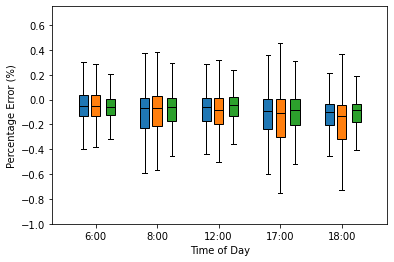

In [370]:
fig, ax = plt.subplots(1, 1)
bp = ax.boxplot([i.cpu().numpy() for i in combination_result], widths=0.15, patch_artist=True, positions = [i - 0.20 for i in range(len(dual_exclusive_result))])
bps = ax.boxplot([i.cpu().numpy() for i in single_exclusive_result], widths=0.15, patch_artist=True, positions = [i for i in range(len(dual_exclusive_result))])
bpd = ax.boxplot([i.cpu().numpy() for i in dual_exclusive_result], widths=0.15, patch_artist=True, positions = [i + 0.24 for i in range(len(dual_exclusive_result))])

ax.set_xlabel('Time of Day')
ax.set_ylabel('Percentage Error (%)')

for flier in bp['fliers']:
    flier.set(marker='x',
              color=colors[0],
              alpha=0.0)
for patch in bp['boxes']:
    patch.set_facecolor(colors[0])
for median in bp['medians']:
    median.set(color='black',
               linewidth=1)
    
for flier in bps['fliers']:
    flier.set(marker='x',
              color=colors[0],
              alpha=0.0)
for patch in bps['boxes']:
    patch.set_facecolor(colors[1])
for median in bps['medians']:
    median.set(color='black',
               linewidth=1)
    
for flier in bpd['fliers']:
    flier.set(marker='x',
              color=colors[0],
              alpha=0.0)
for patch in bpd['boxes']:
    patch.set_facecolor(colors[2])
for median in bpd['medians']:
    median.set(color='black',
               linewidth=1)

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['6:00', '8:00', '12:00', '17:00', '18:00'])

ax.set_ylim(-1, 0.75)

In [338]:
fig.savefig("images/time_vs_accuracy.png", dpi=300)

# Effect on Weather on Accuracy

In [349]:
# single vs dual
weather_variation_dataset = [load_compiled_data(ts=[2], ws=[i], rs=[1,2,3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold,
                                                output_directory='output/object_detector', inference_mode=False, device=device, verbose=False) for i in [1, 3, 4, 5]]

single_exclusive_x = [torch.cat((torch.stack((data['single']['cam_1']['x'], torch.zeros(data['single']['cam_1']['x'].shape, device=data['single']['cam_1']['x'].device))), torch.stack((torch.zeros(data['single']['cam_2']['x'].shape, device=data['single']['cam_2']['x'].device), data['single']['cam_2']['x']))), dim=1) for data in weather_variation_dataset]
single_exclusive_y = [torch.cat((data['single']['cam_1']['y'], data['single']['cam_2']['y'])) for data in weather_variation_dataset]

dual_exclusive_x = [torch.stack((data['dual']['cam_1']['x'], data['dual']['cam_2']['x'])) for data in weather_variation_dataset]
dual_exclusive_y = [data['dual']['cam_1']['y'] for data in weather_variation_dataset]

# inference
single_exclusive_result = [(model(single_exclusive_x[i]) - single_exclusive_y[i][:, 0]) * 100 / single_exclusive_y[i][:, 0]
                           for i in range(len(single_exclusive_x))]
dual_exclusive_result = [(model(dual_exclusive_x[i]) - dual_exclusive_y[i][:, 0]) * 100 / dual_exclusive_y[i][:, 0]
                         for i in range(len(dual_exclusive_x))] 

  0%|          | 0/32685 [00:00<?, ?it/s]

  0%|          | 0/28069 [00:00<?, ?it/s]

  0%|          | 0/12028 [00:00<?, ?it/s]

  0%|          | 0/27503 [00:00<?, ?it/s]

  0%|          | 0/15647 [00:00<?, ?it/s]

  0%|          | 0/12603 [00:00<?, ?it/s]

  0%|          | 0/5071 [00:00<?, ?it/s]

  0%|          | 0/12229 [00:00<?, ?it/s]

In [350]:
# combination
weather_variation_dataset = [load_compiled_data(ts=[2], ws=[i], rs=[1, 2, 3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold,
                                                output_directory='output/object_detector', inference_mode=True, device=device, verbose=False) for i in [1, 3, 4, 5]]

combination_x = [data['x'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)] for data in weather_variation_dataset]
combination_y = [data['y'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)][0] for data in weather_variation_dataset]

# inference
combination_result = [(model(combination_x[i]) - combination_y[i][:, 0]) * 100 / combination_y[i][:, 0] for i in range(len(combination_x))]

  0%|          | 0/17038 [00:00<?, ?it/s]

  0%|          | 0/15466 [00:00<?, ?it/s]

  0%|          | 0/6957 [00:00<?, ?it/s]

  0%|          | 0/15274 [00:00<?, ?it/s]

In [341]:
print("Single View Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in single_exclusive_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in single_exclusive_result]}")
print("")
print("Dual View Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in dual_exclusive_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in dual_exclusive_result]}")
print("")
print("Combination Result")
print(f"MAPE : {[round(abs(i).mean().item(), 8) for i in combination_result]}")
print(f"STD  : {[round(i.std().item(), 8) for i in combination_result]}")

Single View Result
MAPE : [0.22229363, 0.35171527, 0.15782343, 0.23960678]
STD  : [0.6213544, 0.90632522, 0.53440773, 0.55766851]

Dual View Result
MAPE : [0.09962514, 0.22028159, 0.09318904, 0.10842402]
STD  : [0.14617462, 0.67503911, 0.08857792, 0.15183264]

Combination Result
MAPE : [0.18136421, 0.30121613, 0.2095546, 0.17877969]
STD  : [0.74935204, 0.91025305, 0.69651753, 0.57245177]


(-1.5, 1.7)

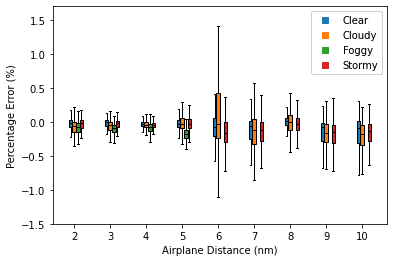

In [342]:
key_distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
err_per_dist = [[combination_result[weather].detach().cpu().numpy()[np.logical_and(combination_y[weather][:, 0].detach().cpu().numpy()*10 <= (i+0.5), combination_y[weather][:, 0].detach().cpu().numpy()*10 > (
    i-0.5))] for i in key_distances] for weather in range(len(combination_y))]

fig, ax = plt.subplots(1, 1)
bps = []
for i in range(len(err_per_dist)):
    bps.append(ax.boxplot(err_per_dist[i], widths=0.1, patch_artist=True,
               positions=key_distances-(0.1*(len(err_per_dist)-i) - 0.3)))

for i in range(len(bps)):
    for flier in bps[i]['fliers']:
        flier.set(marker='x',
                  color=colors[i],
                  alpha=0.0)

    for patch in bps[i]['boxes']:
        patch.set_facecolor(colors[i])

    for median in bps[i]['medians']:
        median.set(color='black',
                   linewidth=1)

#ax.set_title('Effect on Weather on Accuracy')
ax.set_xlabel('Airplane Distance (nm)')
ax.set_ylabel('Percentage Error (%)')


ax.set_xticks(key_distances)
ax.set_xticklabels(key_distances)

custom_lines_1 = [Line2D([0], [0], color=i, lw=0, marker='s') for i in colors]

legend1 = ax.legend(
    custom_lines_1, ['Clear', 'Cloudy', 'Foggy', 'Stormy'], loc='upper right')
ax.add_artist(legend1)
ax.set_ylim(-1.5, 1.7)

In [427]:
# combination
weather_variation_dataset = [load_compiled_data(ts=[2], ws=[i], rs=[2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold,
                                                output_directory='output/object_detector', inference_mode=True, device=device, verbose=False) for i in [3]]

combination_x = [data['x'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)] for data in weather_variation_dataset]
combination_y = [data['y'][:, torch.any(torch.all(data['x'] != 0, dim = 2), dim = 0)][0] for data in weather_variation_dataset]

# inference
combination_result = [(model(combination_x[i]) - combination_y[i][:, 0]) * 100 / combination_y[i][:, 0] for i in range(len(combination_x))]

  0%|          | 0/5307 [00:00<?, ?it/s]

(-1.5, 1.7)

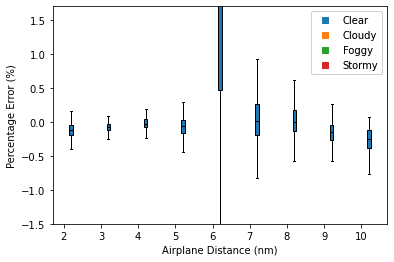

In [428]:
key_distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
err_per_dist = [[combination_result[weather].detach().cpu().numpy()[np.logical_and(combination_y[weather][:, 0].detach().cpu().numpy()*10 <= (i+0.5), combination_y[weather][:, 0].detach().cpu().numpy()*10 > (
    i-0.5))] for i in key_distances] for weather in range(len(combination_y))]

fig, ax = plt.subplots(1, 1)
bps = []
for i in range(len(err_per_dist)):
    bps.append(ax.boxplot(err_per_dist[i], widths=0.1, patch_artist=True,
               positions=key_distances-(0.1*(len(err_per_dist)-i) - 0.3)))

for i in range(len(bps)):
    for flier in bps[i]['fliers']:
        flier.set(marker='x',
                  color=colors[i],
                  alpha=0.0)

    for patch in bps[i]['boxes']:
        patch.set_facecolor(colors[i])

    for median in bps[i]['medians']:
        median.set(color='black',
                   linewidth=1)

#ax.set_title('Effect on Weather on Accuracy')
ax.set_xlabel('Airplane Distance (nm)')
ax.set_ylabel('Percentage Error (%)')


ax.set_xticks(key_distances)
ax.set_xticklabels(key_distances)

custom_lines_1 = [Line2D([0], [0], color=i, lw=0, marker='s') for i in colors]

legend1 = ax.legend(
    custom_lines_1, ['Clear', 'Cloudy', 'Foggy', 'Stormy'], loc='upper right')
ax.add_artist(legend1)
ax.set_ylim(-1.5, 1.7)

In [442]:
data = combination_x[0][:, torch.logical_and(combination_y[0][:, 0] <= 0.65, combination_y[0][:, 0] >= 0.55)]

In [448]:
gt = combination_y[0][torch.logical_and(combination_y[0][:, 0] <= 0.65, combination_y[0][:, 0] >= 0.55)][:, 0]

In [449]:
pred = model(data)

  0%|          | 0/609 [00:00<?, ?it/s]

In [473]:
combination_x[0][0, :, 0]

tensor([0.0118, 0.0124, 0.0123,  ..., 0.9956, 0.9960, 0.9966], device='cuda:0')

In [465]:
ff = torch.all(torch.all(data!=0 , dim=2), dim=0).cpu().numpy()

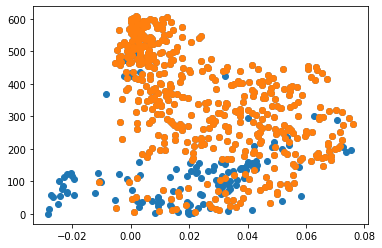

In [560]:
plt.scatter(((pred-gt)/gt).detach().cpu().numpy(), np.arange(0, len(pred)))
plt.scatter(((pred-gt)/gt).detach().cpu().numpy()[ff], np.arange(0, len(pred))[ff])

In [437]:
print(abs(combination_result[0][torch.logical_and(combination_y[0][:, 0] <= 0.65, combination_y[0][:, 0] >= 0.55)]).mean())
print(combination_result[0][torch.logical_and(combination_y[0][:, 0] <= 0.65, combination_y[0][:, 0] >= 0.55)].std())

tensor(2.5332, device='cuda:0')
tensor(2.2648, device='cuda:0')


In [343]:
fig.savefig("images/weather_vs_accuracy.png", dpi=300)

# Architecture Search

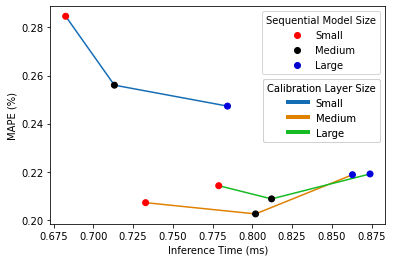

In [94]:
test_data = load_compiled_data(ts=[2, 3, 4], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode=True, device=device, verbose=False)
ff = torch.any(torch.all(test_data['x'] != 0, dim=2), dim=0)
init = init_list[0]
with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'rb') as f:
    output_dict, time_dict = pkl.load(f)
best_mape = {}
for i in output_dict.keys():
    best_mape[i] = torch.mean(torch.mean(abs(output_dict[i].cuda(
    ) - test_data['y'][0, ff, 0]) * 100 / test_data['y'][0, ff, 0], axis=1)).item()
output_s = [best_mape[i] for i in ['s_s', 's_m', 's_l']]
output_m = [best_mape[i] for i in ['m_s', 'm_m', 'm_l']]
output_l = [best_mape[i] for i in ['l_s', 'l_m', 'l_l']]
time_s = [time_dict[model_type] * 1000 for model_type in ['s_s', 's_m', 's_l']]
time_m = [time_dict[model_type] * 1000 for model_type in ['m_s', 'm_m', 'm_l']]
time_l = [time_dict[model_type] * 1000 for model_type in ['l_s', 'l_m', 'l_l']]

fig, ax = plt.subplots(1, 1)
cmap1 = plt.cm.flag
cmap2 = plt.cm.viridis
ax.scatter(time_s, output_s, c=[0, 1, 2],
           vmin=0, vmax=20, cmap='flag', zorder=2)
ax.scatter(time_m, output_m, c=[0, 1, 2],
           vmin=0, vmax=20, cmap='flag', zorder=2)
ax.scatter(time_l, output_l, c=[0, 1, 2],
           vmin=0, vmax=20, cmap='flag', zorder=2)

#ax.set_title("Model Types Comparison")
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Inference Time (ms)')

ax.plot(time_s, output_s, zorder=1, c='#156DB6')
ax.plot(time_m, output_m, zorder=1, c='#DF8000')
ax.plot(time_l, output_l, zorder=1, c='#17BB24')


custom_lines_1 = [Line2D([0], [0], color=cmap1(0), lw=0, marker='o', markersize=6),
                  Line2D([0], [0], color=cmap1(1000),
                         lw=0, marker='o', markersize=6),
                  Line2D([0], [0], color=cmap1(9), lw=0, marker='o', markersize=6)]

custom_lines_2 = [Line2D([0], [0], color='#156DB6', lw=4),
                  Line2D([0], [0], color='#DF8000', lw=4),
                  Line2D([0], [0], color='#17BB24', lw=4)]


legend1 = ax.legend(custom_lines_1, [
                    'Small', 'Medium', 'Large'], title="Sequential Model Size", loc='upper right')
ax.add_artist(legend1)
legend2 = ax.legend(custom_lines_2, ['Small', 'Medium', 'Large'],
                    title="Calibration Layer Size", loc='upper center', bbox_to_anchor=[0.810, 0.69])
ax.add_artist(legend2)

In [95]:
fig.savefig("images/architecture_search.png", dpi=300)

In [587]:
test_dataset = load_compiled_data(ts=[1], ws=[1], rs=[1,2,3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold,
                                                output_directory='output/object_detector', inference_mode=True, device=device, verbose=False)


#  Per-pixel Significance

In [623]:
# Normalizing 1 pixel 
unit_x = torch.tensor([[1,1,1,1],[1,1,1,1]]) / torch.tensor(offset)

In [675]:
test_x = test_dataset['x'][:, torch.all(torch.all(test_dataset['x'] != 0, dim = 2), dim = 0)]
test_y = test_dataset['y'][:, torch.all(torch.all(test_dataset['x'] != 0, dim = 2), dim = 0)]

In [715]:
# Categorizing the dataset based on distances
key_distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
x_per_dist = [test_x[:, torch.logical_and(test_y[0][:, 0] * 10 > i - 0.5, test_y[0][:, 0] * 10 <= i + 0.5)] for i in key_distances]
y_per_dist = [test_y[0, torch.logical_and(test_y[0][:, 0] * 10 > i - 0.5, test_y[0][:, 0] * 10 <= i + 0.5), 0] for i in key_distances]

In [795]:
# Initial Inference
original_pred = [model(i, verbose = False) for i in x_per_dist]

# cam 1 exclusive
x_per_dist_cam_1 = [i.clone() for i in x_per_dist]
for i in x_per_dist_cam_1:
    i[1] = 0
original_pred_cam_1 = [model(i, verbose = False) for i in x_per_dist_cam_1]

# cam 2 exclusive
x_per_dist_cam_2 = [i.clone() for i in x_per_dist]
for i in x_per_dist_cam_2:
    i[0] = 0
original_pred_cam_2 = [model(i, verbose = False) for i in x_per_dist_cam_2]

In [812]:
# Modifying the dataset [+- 1 pixel (which has been normalized)]
x_per_dist_positive_delta = [i.clone() for i in x_per_dist]
x_per_dist_negative_delta = [i.clone() for i in x_per_dist]

# a = cam, b = [x,y,w,h]
a, b = 1, 1

for i in x_per_dist_positive_delta:
    i[a, :, b] += unit_x[a, b]
for i in x_per_dist_negative_delta:
    i[a, :, b] -= unit_x[a, b]

# single camera filter
for i in x_per_dist_positive_delta:
    i[0] = 0
for i in x_per_dist_negative_delta:
    i[0] = 0

In [815]:
positive_delta = [model(x_per_dist_positive_delta[i]) - original_pred_cam_2[i] for i in range(len(x_per_dist))]
negative_delta = [model(x_per_dist_negative_delta[i]) - original_pred_cam_2[i] for i in range(len(x_per_dist))]

delta = [torch.cat((positive_delta[i], negative_delta[i])) for i in range(len(positive_delta))]
for i in [round(abs(i).mean().item() * 10, 4) for i in delta]:
    print(str(i))

  0%|          | 0/1766 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1808 [00:00<?, ?it/s]

  0%|          | 0/1821 [00:00<?, ?it/s]

  0%|          | 0/1843 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1891 [00:00<?, ?it/s]

  0%|          | 0/1602 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/1766 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1808 [00:00<?, ?it/s]

  0%|          | 0/1821 [00:00<?, ?it/s]

  0%|          | 0/1843 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1891 [00:00<?, ?it/s]

  0%|          | 0/1602 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

0.0002
0.0003
0.0003
0.0007
0.0045
0.0077
0.0112
0.0059
0.0014


In [505]:
model(torch.tensor([[[1,1,1,1]], [[0,0,0,0]]], device = device).float())

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.1534], device='cuda:0')

In [136]:
import torchinfo
model = ensemble(
    f'models/config/model_{model_list[8]}.yaml', device=device, num_camera=2)
torchinfo.summary(model, input_size=(1, 1, 4))

  0%|          | 0/1 [00:00<?, ?it/s]

Layer (type:depth-idx)                   Output Shape              Param #
ensemble                                 [1]                       131,585
├─ModuleList: 1-1                        --                        198,656
│    └─Sequential: 2-1                   [1, 512]                  --
│    │    └─Linear: 3-1                  [1, 256]                  1,280
│    │    └─LeakyReLU: 3-2               [1, 256]                  --
│    │    └─Linear: 3-3                  [1, 256]                  65,792
│    │    └─LeakyReLU: 3-4               [1, 256]                  --
│    │    └─Linear: 3-5                  [1, 512]                  131,584
│    │    └─LeakyReLU: 3-6               [1, 512]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─LSTM: 2-2                         [1, 1, 1024]              23,093,248
│    └─extract_tensor: 2-3               [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]      